In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import pandas as pd
import numpy as np
from math import sqrt

def preprocess_data(file_path):
    '''
    Preprocess the data including splitting and normalization
    '''
    data = pd.read_csv(file_path)
    data["Date Time"] = pd.to_datetime(data["Date Time"], format="%d.%m.%Y %H:%M:%S", errors='coerce')
    data = data.set_index('Date Time')

    # Select target variable
    target_column = "T (degC)"
    values = data[target_column].values.reshape(-1, 1)

    # Scale data
    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(values)

    # Split data into sequences
    sequence_length = 72 
    X, y = [], []
    for i in range(len(values_scaled) - sequence_length):
        X.append(values_scaled[i:i + sequence_length])
        y.append(values_scaled[i + sequence_length])
    X, y = np.array(X), np.array(y)

    # Train-test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f"Data preprocessing complete. Train size: {len(X_train)}, Test size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, scaler

In [30]:
def build_lstm_model(input_shape):
    '''
    Building the model according to given parameters
    '''
    #Parameters used according to the Hugging Face project
    model = models.Sequential([
        layers.LSTM(
            units=50, 
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            kernel_initializer="glorot_uniform",
            recurrent_initializer="orthogonal",
            bias_initializer="zeros",
            unit_forget_bias=True,
            dropout=0.0,
            recurrent_dropout=0.0,
            return_sequences=False,
            return_state=False,
            go_backwards=False,
            stateful=False,
            unroll=False,
            input_shape=input_shape,
            use_cudnn="auto"
        ),
        layers.Dense(1)
    ])

    optimizer = optimizers.Adam(
        learning_rate=0.0010000000474974513,
        beta_1=0.8999999761581421,
        beta_2=0.9990000128746033,
        epsilon=1e-07,
        amsgrad=False
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=optimizer
    )

    print("LSTM model built successfully.")
    return model

In [31]:
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=3, batch_size=64):
    '''
    Train the model
    '''
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    print("Training complete.")
    return history

In [32]:
def make_predictions(model, test_X, scaler):
    """
    Generate predictions using the trained model and scale back to original units.
    """
    predictions = model.predict(test_X)
    
    # Reshape predictions and invert scaling
    predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
    predictions = scaler.inverse_transform(predictions)

    return predictions

In [33]:
def compute_rmse(true_values, predicted_values):
    """
    Compute the RMSE between true and predicted values.
    """
    rmse = sqrt(mean_squared_error(true_values, predicted_values))
    print(f"RMSE: {rmse}")
    return rmse

In [34]:
def plot_predictions(actual, predicted):
    """
    Plot the actual temperature vs predicted temperature values.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(actual, label="Actual Temperature", color="blue")
    plt.plot(predicted, label="Predicted Temperature", color="orange", linestyle="--")
    plt.xlabel("Time Step")
    plt.ylabel("Temperature (in original scale)")
    plt.title("Comparison of Actual and Predicted Temperature")
    plt.legend()
    plt.show()

Data preprocessing complete. Train size: 336383, Test size: 84096
LSTM model built successfully.
Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5256/5256 ━━━━━━━━━━━━━━━━━━━━ 93s 18ms/step - loss: 0.0030 - val_loss: 3.1693e-05
Epoch 2/5
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 85s 16ms/step - loss: 2.7819e-05 - val_loss: 1.7090e-05
Epoch 3/5
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - loss: 1.4938e-05 - val_loss: 1.7447e-05
Epoch 4/5
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - loss: 1.2762e-05 - val_loss: 1.5682e-05
Epoch 5/5
5256/5256 ━━━━━━━━━━━━━━━━━━━━ 87s 17ms/step - loss: 1.2418e-05 - val_loss: 1.4825e-05
Training complete.
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
RMSE: 0.23213223489374352


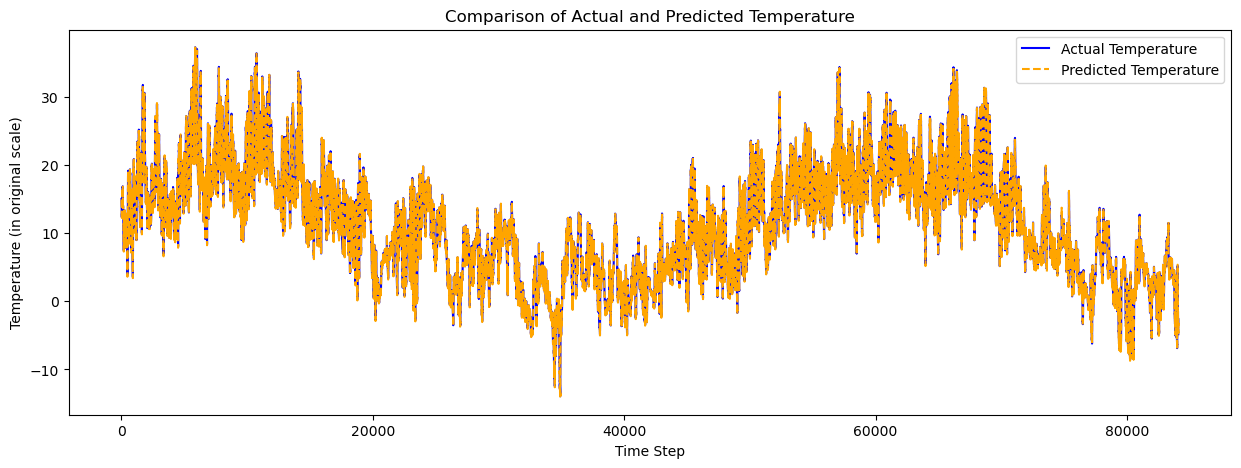

LSTM Hyperparameters:
           Parameter   Value
               Units     128
          Activation    tanh
Recurrent Activation sigmoid
             Dropout     0.2
   Recurrent Dropout     0.2
           Optimizer    Adam
       Learning Rate   0.001
          Batch Size      64
              Epochs       5


In [35]:
def main():
    # Define file path for the dataset
    file_path = "jena_climate_2009_2016.csv"

    # Preprocess data
    X_train, X_test, y_train, y_test, scaler = preprocess_data(file_path)

    # Build and compile the model
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=5, batch_size=64)

    # Generate predictions
    predictions = make_predictions(model, X_test, scaler)
    
    # Invert scaling for test_y as well
    y_test = y_test.reshape((-1, 1))
    y_test = scaler.inverse_transform(y_test)
    
    # Compute RMSE
    compute_rmse(y_test, predictions)

    # Generate plot
    plot_predictions(y_test.flatten(), predictions.flatten())

    lstm_hyperparameters = {
    "Parameter": [
        "Units", "Activation", "Recurrent Activation", "Dropout", 
        "Recurrent Dropout", "Optimizer", "Learning Rate", "Batch Size", 
        "Epochs"
    ],
    "Value": [
        128, "tanh", "sigmoid", 0.2, 0.2, 
        "Adam", 0.001, 64, 5
    ]
    }

    lstm_table = pd.DataFrame(lstm_hyperparameters)
    print("LSTM Hyperparameters:")
    print(lstm_table.to_string(index=False))

if __name__ == "__main__":
    main()